In [20]:
!pip install tensorflow==2.18.0

In [34]:
# Step 1: Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import shutil
import random
from zipfile import ZipFile
from google.colab import files
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # For MobileNetV2 preprocessing
from tensorflow.keras.models import Model  # For the functional API (MobileNetV2 model)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout  # For custom layers after MobileNetV2

In [22]:
!pip install -U gdown

In [23]:
!gdown --id 1zsy20lvgBpnm0_qSCTTCwmNx0dZp_EMu

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1zsy20lvgBpnm0_qSCTTCwmNx0dZp_EMu
From (redirected): https://drive.google.com/uc?id=1zsy20lvgBpnm0_qSCTTCwmNx0dZp_EMu&confirm=t&uuid=93eb2a69-bc5b-4458-8590-750d036dd9bc
To: /content/archive.zip
100% 690M/690M [00:16<00:00, 42.0MB/s]


In [24]:
# List all files in the current directory
os.listdir()

['.config', 'PlantVillage', 'data', 'archive.zip', 'sample_data']

In [25]:
# Step 2: Extract the dataset
import zipfile

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("PlantVillage")

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [26]:
# Step 3: Define Dataset Path and List Classes
dataset_path = os.path.join('PlantVillage', 'plantvillage', 'PlantVillage')

# List all class folders (types of diseases + healthy)
classes = os.listdir(dataset_path)
print("Total Classes:", len(classes))
print("Classes Found:", classes)


Total Classes: 15
Classes Found: ['Tomato_Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato__Tomato_mosaic_virus', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Tomato_healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Pepper__bell___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot']


**Exploratory Data Analysis (EDA)**

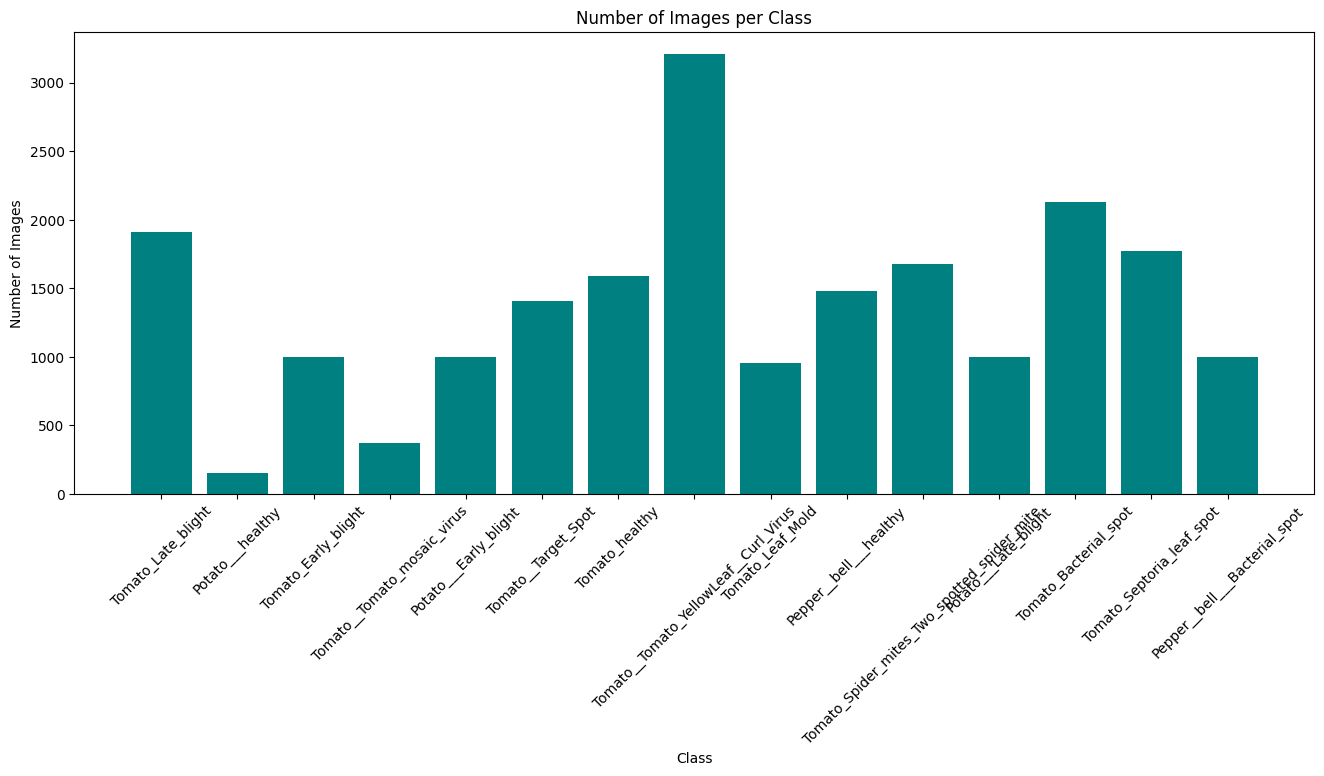

In [27]:
# Step 4: (Count Images per class)
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Plot class distribution:
plt.figure(figsize=(16, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

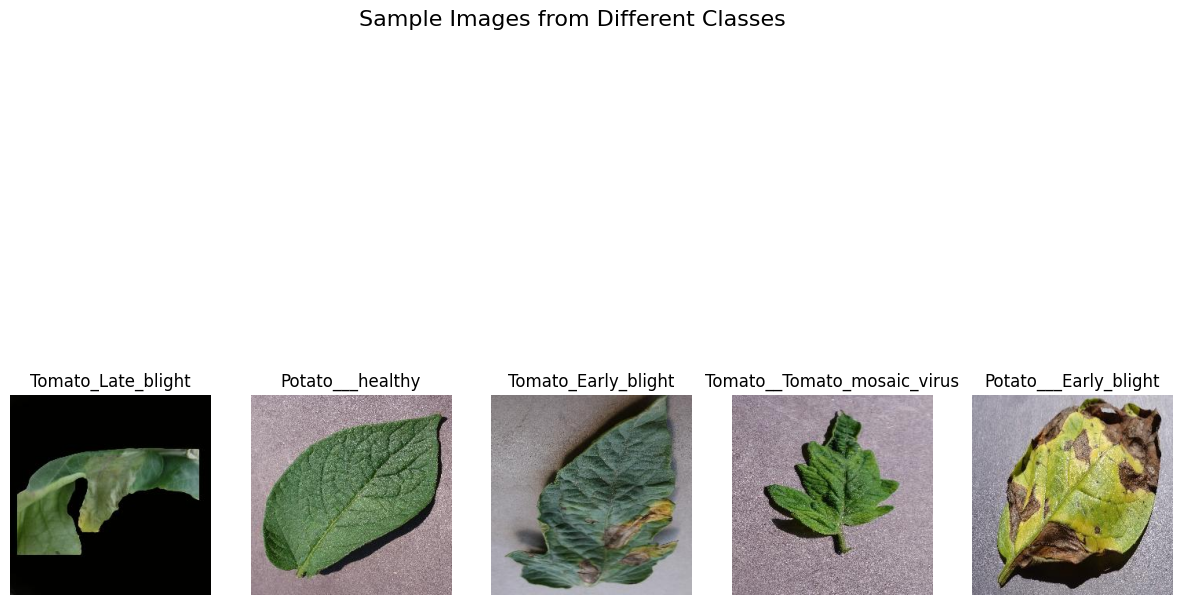

In [28]:
# (Show sample images from 1st 5 classes):

num_samples = 5  # Number of classes to display
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes[:num_samples]):  # Loop over first 5 classes
    folder_path = os.path.join(dataset_path, cls)  # dataset path
    sample_image = os.listdir(folder_path)[0]  # get first image in that class
    img = mpimg.imread(os.path.join(folder_path, sample_image))
    plt.subplot(1, num_samples, i+1)  # Create a subplot for each image
    plt.imshow(img)
    plt.title(cls)  # Set the class name as the title
    plt.axis('off')

plt.suptitle("Sample Images from Different Classes", fontsize=16)
plt.show()

**Create Train/Test Folders and Split Data (80/20)**

In [29]:
# Step 5: Create train/test folders
base_dir = os.path.join('PlantVillage', 'plantvillage', 'PlantVillage')
train_dir = 'data/train'
test_dir = 'data/test'

# Train and Test directories/folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over all disease/healthy classes:
for cls in classes:
    os.makedirs(f'{train_dir}/{cls}', exist_ok=True) # Make sub-folder for each class in train
    os.makedirs(f'{test_dir}/{cls}', exist_ok=True)  # Make sub-folder for each class in test

    all_imgs = os.listdir(f'{dataset_path}/{cls}')  # List all images in current class
    random.shuffle(all_imgs) # Shuffle images for randomness

    # Split data: 80% for training, remaining 20% for testing
    split_idx = int(0.8 * len(all_imgs))
    train_imgs = all_imgs[:split_idx]
    test_imgs = all_imgs[split_idx:]

    # Copy files to train directory
    for img in train_imgs:
        shutil.copy(f'{base_dir}/{cls}/{img}', f'{train_dir}/{cls}/{img}')

    # Copy files to test directory
    for img in test_imgs:
        shutil.copy(f'{base_dir}/{cls}/{img}', f'{test_dir}/{cls}/{img}')

print("Dataset reorganized successfully!")

Dataset reorganized successfully!


**Define Image Size & Set Paths**

In [30]:
# Step 6:
IMAGE_SIZE = [224, 224]
train_path = 'data/train'
valid_path = 'data/test'

**Data Augmentation and Preprocessing**

In [31]:
# Step:7
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size=IMAGE_SIZE,
                                            batch_size=32,
                                            class_mode='categorical')


Found 20477 images belonging to 15 classes.
Found 10106 images belonging to 15 classes.


 **Build CNN Model**

In [35]:
# Step 8: Build the Model using Transfer Learning (MobileNetV2)

# Load the base model (pre-trained)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')  # Use weights trained on ImageNet

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(classes), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Compile Model**

In [36]:
# Step 9:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train the Model**

In [37]:
# Step 10:
history = model.fit(training_set,
                    validation_data=test_set,
                    epochs=10,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(test_set))

Epoch 1/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1539s 2s/step - accuracy: 0.5903 - loss: 1.3333 - val_accuracy: 0.8505 - val_loss: 0.4649
Epoch 2/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1581s 2s/step - accuracy: 0.8342 - loss: 0.5142 - val_accuracy: 0.8699 - val_loss: 0.3881
Epoch 3/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1493s 2s/step - accuracy: 0.8604 - loss: 0.4198 - val_accuracy: 0.8994 - val_loss: 0.3060
Epoch 4/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1524s 2s/step - accuracy: 0.8677 - loss: 0.3893 - val_accuracy: 0.8915 - val_loss: 0.3159
Epoch 5/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1530s 2s/step - accuracy: 0.8751 - loss: 0.3687 - val_accuracy: 0.8996 - val_loss: 0.2988
Epoch 6/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1489s 2s/step - accuracy: 0.8833 - loss: 0.3479 - val_accuracy: 0.9061 - val_loss: 0.2781
Epoch 7/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1511s 2s/step - accuracy: 0.8819 - loss: 0.3399 - val_accuracy: 0.9182 - val_loss: 0.2465
Epoch 8/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1550s 2s/step - accuracy: 0.8816 - loss: 0.3472 - 

**Evaluate the Model**

Accuracy Plot

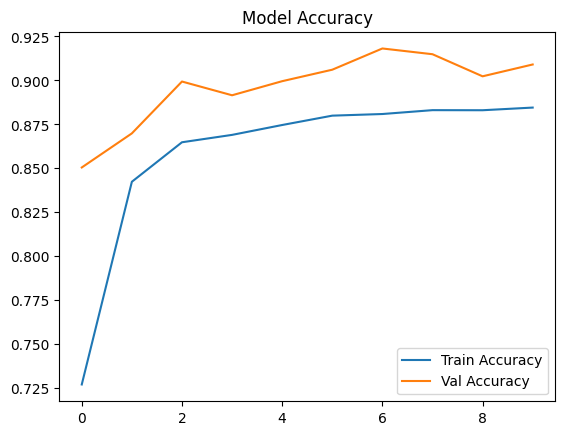

In [38]:
# Step 11:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

We observe a sharp rise in training accuracy from ~72% to ~89% within the first few epochs, while validation accuracy remains consistently high (peaking around 92%).
This indicates that by using  MobileNetV2 it quickly learned to classify plant leaf diseases effectively with minimal overfitting.
Impact: High accuracy ensures reliable early detection of diseases like blight, mold, or viruses in tomato and potato leaves — crucial for timely treatment and reducing crop loss.

Loss Plot

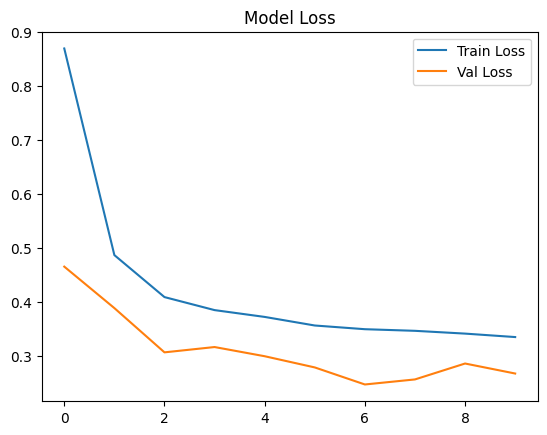

In [39]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

Both training and validation loss drop steadily, indicating improved learning and reduced error over time.
Low final loss (~0.3) reflects a well-generalized model, making it effective for real-world leaf disease diagnosis.

**Confusion Matrix & Classification Report & Confusion Matrix**

In [40]:
# Step 12:
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

print("Classification Report:")
print(classification_report(test_set.classes, y_pred, target_names=test_set.class_indices.keys()))

316/316 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.04      0.04      0.04       494
                     Pepper__bell___healthy       0.08      0.08      0.08       723
                      Potato___Early_blight       0.05      0.05      0.05       494
                       Potato___Late_blight       0.05      0.04      0.04       477
                           Potato___healthy       0.03      0.03      0.03        76
                      Tomato_Bacterial_spot       0.11      0.11      0.11      1056
                        Tomato_Early_blight       0.02      0.02      0.02       486
                         Tomato_Late_blight       0.08      0.08      0.08       933
                           Tomato_Leaf_Mold       0.05      0.06      0.06       476
                  Tomato_Septoria_leaf_spot       0.10      0.09      0.09       860

316/316 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step


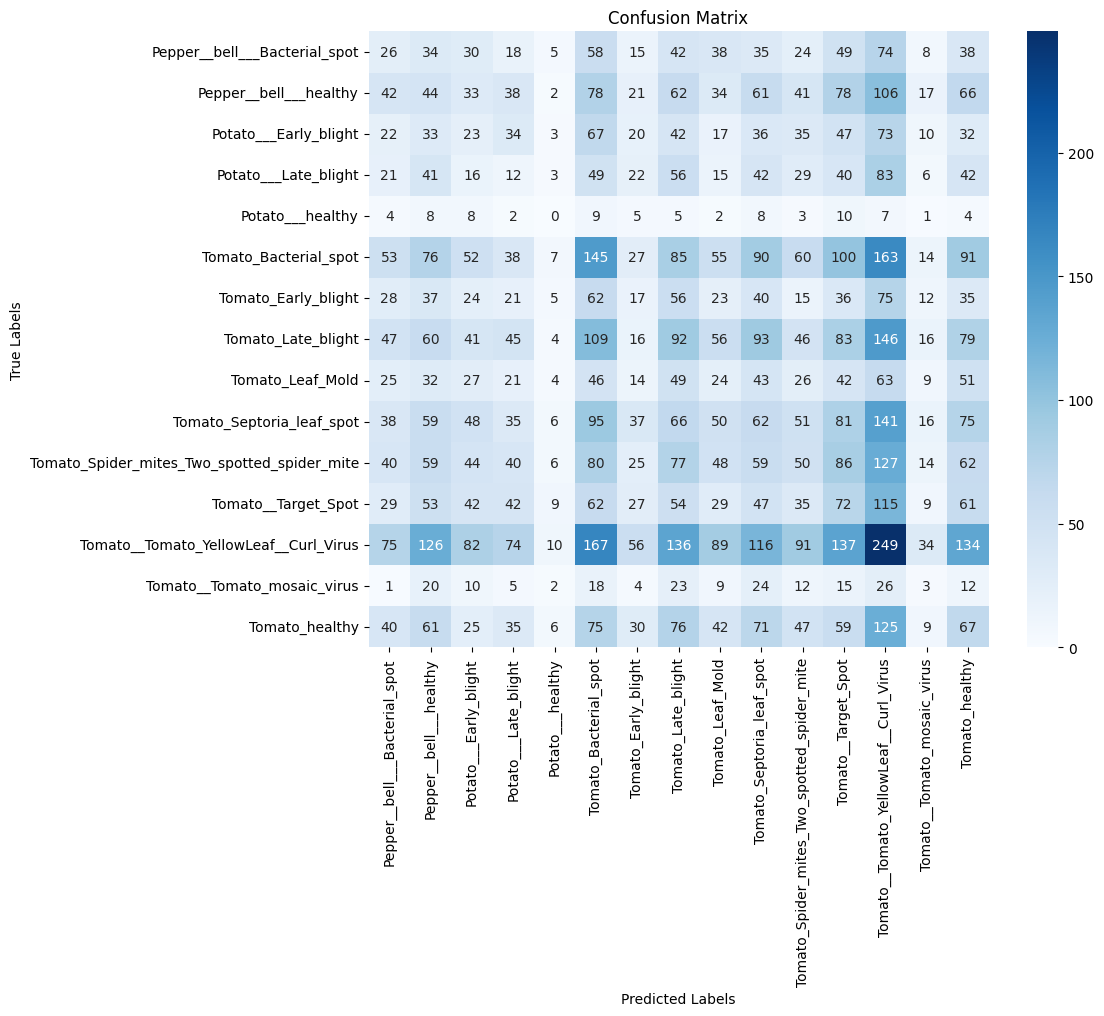

In [41]:
import seaborn as sns
# Predict the classes on the test set
y_pred_probs = model.predict(test_set)

# Convert the probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the test_set
y_true = test_set.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.class_indices, yticklabels=test_set.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Each row = actual disease;
Each column = model’s predicted disease.
Darker cells = more predictions for that pair.
As in Tomato Yellow Leaf Curl Virus, 249 times it was correctly predicted, but many times confused with others like Bacterial Spot or Target Spot.
High Misclassifications

A large number of classes are misclassified into other classes, especially among Tomato diseases.

Tomato_healthy → misclassified as Tomato_YellowLeaf_Curl_Virus

Tomato_Late_blight → confused with Tomato_Septoria_leaf_spot and Tomato_Target_Spot

Rare classes like Potato_healthy (only 76 samples) show very poor prediction.

The model seems biased toward more frequent classes (like Tomato diseases).

**Prediction on New Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted Class: Tomato_healthy


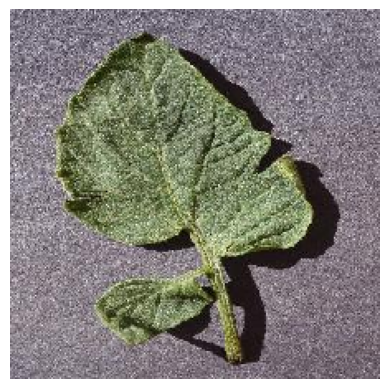

In [44]:
# STEP 13:

# Correct path to image folder
img_path = 'data/test/Tomato_healthy'

# Load and show the image
img = image.load_img(os.path.join(img_path, os.listdir(img_path)[0]), target_size=IMAGE_SIZE)
plt.imshow(img)
plt.axis('off')

# Preprocessing
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.

# Prediction
prediction = model.predict(img)
predicted_class = list(test_set.class_indices.keys())[np.argmax(prediction)]
print("Predicted Class:", predicted_class)